In [8]:
# clean_fact_client_monthly.py
# ==========================================================
# Purpose:
#   - Clean and prepare analytics.fact_client_monthly
#   - Steps: check duplicates, missing values, type coercion, clamp ranges,
#            fix inconsistencies, and report issues
# ==========================================================

import pandas as pd
import numpy as np

# ---------- Import CSV at the beginning ----------
# Define file paths (you can change them as needed)
INPUT_FILE = "C:/Users/Reverside/Downloads/fact_client_monthly.csv"      # Raw input file
OUTPUT_FILE = "fact_client_monthly_clean.csv"   # Cleaned output file

# Load the raw dataset from CSV into a pandas DataFrame
df_raw = pd.read_csv(INPUT_FILE)
display(df_raw.head())
# ---------------- CONFIG: define which columns belong to which type ----------------
# Primary key columns (the natural grain of this fact table)
KEY = ["client_sk", "month_sk"]

# Continuous numeric variables (balances, amounts, rates, etc.)
NUM_CONT = [
    "avg_balance", "inflow_amount", "outflow_amount",
    "avg_ticket_size", "email_open_rate", "email_ctr"
]

# Discrete numeric variables (counts, integers, transaction numbers)
NUM_DISC = ["inflow_txn_cnt", "outflow_txn_cnt", "digital_logins_cnt", "days_active"]

# Boolean flags (yes/no)
BOOLS = [
    "intl_txn_flag", "self_service_usage_flag",
    "has_merchant", "has_forex", "has_payroll", "has_savings"
]

# # Primary + foreign key columns (store as strings, not numbers)
ID_COLS = ["client_sk", "month_sk", "last_campaign_sk"]

# Defaults for missing values
DEFAULT_ZERO = NUM_CONT + NUM_DISC    # numeric → fill missing with 0
DEFAULT_FALSE = BOOLS                 # boolean → fill missing with False

# Logical range rules for some variables
RANGE_RULES = {
    "days_active": (0, 31),           # must be 0–31 days
    "email_open_rate": (0, 100),      # percent between 0–100
    "email_ctr": (0, 100),            # percent between 0–100
}

# ---------------- HELPER FUNCTIONS ----------------
def _coerce_numeric(df, cols, discrete=False):
    """Convert columns to numeric. If invalid values, coerce to NaN.
       If discrete=True, round and store as Int64 (nullable integer)."""
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if discrete:
                df[c] = df[c].round(0).astype("Int64")
    return df

def _coerce_bool(df, cols):
    """Convert columns to pandas nullable Boolean type."""
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype("boolean")
    return df

def _coerce_str(df, cols):
    """Force selected columns to string type for IDs / keys.
       - NaN will be replaced with empty string '' to avoid errors.
       - Keeps consistency across joins and exports.
       - Ensures dtype is 'object' (standard pandas string column)."""
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str).replace("nan", "")
            df[c] = df[c].astype(object)  # explicitly set dtype to object
            print(df[c].dtype)  # Debug: print the dtype to verify
    return df

def _clamp(df, col, lo=None, hi=None):
    """Clamp column values to [lo, hi]."""
    if col not in df.columns:
        return df
    if lo is not None:
        df[col] = np.where(df[col] < lo, lo, df[col])
    if hi is not None:
        df[col] = np.where(df[col] > hi, hi, df[col])
    return df

def _missing_summary(df, cols):
    """Return dictionary of missing counts for each column in cols."""
    summary = {}
    for c in cols:
        if c in df.columns:
            summary[c] = int(df[c].isna().sum())
    return summary

def _clamp_date(df, col, lo, hi):
    """Clamp numeric values like dates or months to range [lo, hi]."""
    df[col] = df[col].clip(lower=lo, upper=hi)
    return df

def _fix_month_sk(df, col="month_sk"):
    """Fix invalid month_sk values by clamping month part to [1–12].
       Example: 202317 → 202312"""
    if col not in df.columns:
        return df, 0

    # Split into year and month
    year = (df[col] // 100).astype("Int64")
    month = (df[col] % 100).astype("Int64")

    # Count invalid months
    invalid_count = ((month < 1) | (month > 12)).sum()

    # Clamp month between 1 and 12
    month = _clamp_date(pd.DataFrame({"m": month}), "m", lo=1, hi=12)["m"]

    # Rebuild month_sk
    df[col] = (year * 100 + month).astype("Int64")

    return df, int(invalid_count)

# ---------------- MAIN CLEANER ----------------
def clean_fact_client_monthly(df: pd.DataFrame, verbose: bool = True):
    """
    Cleans analytics.fact_client_monthly:
      1. Fix month_sk if invalid
      2. Coerce types (numeric, boolean, IDs)
      3. Fill missing values with sensible defaults
      4. Clamp ranges for specific fields
      5. Ensure CTR ≤ Open Rate
      6. Clamp negatives in numeric fields to 0
      7. Remove duplicates on primary keys
      8. Report missing key values
    Returns:
      cleaned_df, qa_report (dict)
    """
    df = df.copy()

    # Step 1: Fix month_sk
    _fix_month_sk(df, "month_sk")

    # Step 2: Coerce types
    _coerce_numeric(df, NUM_CONT, discrete=False)
    _coerce_numeric(df, NUM_DISC, discrete=True)
    _coerce_bool(df, BOOLS)
    _coerce_str(df, ID_COLS)

    # Step 3: Fill missing values
    for c in DEFAULT_ZERO:
        if c in df.columns:
            df[c] = df[c].fillna(0)
    for c in DEFAULT_FALSE:
        if c in df.columns:
            df[c] = df[c].fillna(False)

    # Step 4: Clamp ranges
    for col, (lo, hi) in RANGE_RULES.items():
        _clamp(df, col, lo, hi)

    # Step 5: Ensure CTR ≤ Open Rate
    if {"email_ctr", "email_open_rate"}.issubset(df.columns):
        mask = df["email_ctr"].notna() & df["email_open_rate"].notna()
        df.loc[mask, "email_ctr"] = np.minimum(df.loc[mask, "email_ctr"], df.loc[mask, "email_open_rate"])

    # Step 6: Ensure all numerics are non-negative
    for c in NUM_CONT + NUM_DISC:
        if c in df.columns:
            df[c] = df[c].mask(df[c] < 0, 0)

    # Step 7: Handle duplicates on key
    dup_count = 0
    if all(k in df.columns for k in KEY):
        dup_count = int(df.duplicated(subset=KEY, keep=False).sum())
        df = df.drop_duplicates(subset=KEY, keep="first").reset_index(drop=True)

    # Step 8: Missing summary for primary keys
    miss = _missing_summary(df, [c for c in KEY if c in df.columns])

    # Build QA report
    qa_report = {
        "rows_after_clean": int(len(df)),
        "duplicate_key_rows_removed": int(dup_count // 2) if dup_count else 0,
        "missing_in_keys": miss,
        "clamped_columns": list(RANGE_RULES.keys()),
        "numeric_negatives_clamped_to_zero": NUM_CONT + NUM_DISC,
        "ctr_capped_to_open_rate_applied": bool({"email_ctr","email_open_rate"}.issubset(df.columns)),
    }

    # Print QA summary if verbose
    if verbose:
        print("=== fact_client_monthly: QA Report ===")
        print(f"Rows after clean: {qa_report['rows_after_clean']}")
        print(f"Duplicate key rows removed: {qa_report['duplicate_key_rows_removed']}")
        print(f"Missing in keys: {qa_report['missing_in_keys']}")
        print(f"Clamped columns: {qa_report['clamped_columns']}")
        print(f"Non-negative enforced for: {qa_report['numeric_negatives_clamped_to_zero']}")
        print(f"CTR capped to Open Rate applied: {qa_report['ctr_capped_to_open_rate_applied']}")

    return df, qa_report

# ---------------- RUN CLEANING ----------------
if __name__ == "__main__":
    # Run the cleaner on the raw CSV file
    df_clean, report = clean_fact_client_monthly(df_raw)

    # Save cleaned dataset back to CSV
    # df_clean.to_csv(OUTPUT_FILE, index=False)
    # Before saving, ensure ID_COLS are object dtype
    for col in ID_COLS:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(object)

    df_clean.to_csv(OUTPUT_FILE, index=False)
    print(df_clean.dtypes)  # Debug: print dtypes to verify
    # Print confirmation
    print("\nCleaned dataset saved to:", OUTPUT_FILE)


,client_sk,month_sk,avg_balance,inflow_txn_cnt,outflow_txn_cnt,inflow_amount,outflow_amount,intl_txn_flag,digital_logins_cnt,self_service_usage_flag,avg_ticket_size,days_active,has_merchant,has_forex,has_payroll,has_savings,email_open_rate,email_ctr,last_campaign_sk
0,1,202301,55530.99,20,21,11098.16,10881.11,False,22,False,549.48,20,False,False,True,False,11.99,4.44,NaN
1,1,202302,3354.61,26,17,10244.40,7788.06,True,28,True,411.08,14,False,False,True,False,5.12,1.93,NaN
2,1,202303,16363.78,23,22,22508.00,18985.00,False,38,True,923.48,18,False,False,True,True,0.00,0.00,NaN
3,1,202306,2794.71,19,26,10715.82,16899.99,True,1,False,569.76,11,False,False,True,True,25.78,8.61,NaN
4,1,202307,1469.53,17,20,12396.26,12045.34,True,10,True,631.14,23,True,True,True,True,12.44,4.57,NaN


object
object
object
=== fact_client_monthly: QA Report ===
Rows after clean: 35000
Duplicate key rows removed: 0
Missing in keys: {'client_sk': 0, 'month_sk': 0}
Clamped columns: ['days_active', 'email_open_rate', 'email_ctr']
Non-negative enforced for: ['avg_balance', 'inflow_amount', 'outflow_amount', 'avg_ticket_size', 'email_open_rate', 'email_ctr', 'inflow_txn_cnt', 'outflow_txn_cnt', 'digital_logins_cnt', 'days_active']
CTR capped to Open Rate applied: True
client_sk                   object
month_sk                    object
avg_balance                float64
inflow_txn_cnt               Int64
outflow_txn_cnt              Int64
inflow_amount              float64
outflow_amount             float64
intl_txn_flag              boolean
digital_logins_cnt           Int64
self_service_usage_flag    boolean
avg_ticket_size            float64
days_active                  int64
has_merchant               boolean
has_forex                  boolean
has_payroll                boolean
has_sa

## Use the clean data to do analysis

In [9]:
# display basic info, i.e the number of non-null entries and data types for each column
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_sk                35000 non-null  object 
 1   month_sk                 35000 non-null  object 
 2   avg_balance              35000 non-null  float64
 3   inflow_txn_cnt           35000 non-null  Int64  
 4   outflow_txn_cnt          35000 non-null  Int64  
 5   inflow_amount            35000 non-null  float64
 6   outflow_amount           35000 non-null  float64
 7   intl_txn_flag            35000 non-null  boolean
 8   digital_logins_cnt       35000 non-null  Int64  
 9   self_service_usage_flag  35000 non-null  boolean
 10  avg_ticket_size          35000 non-null  float64
 11  days_active              35000 non-null  int64  
 12  has_merchant             35000 non-null  boolean
 13  has_forex                35000 non-null  boolean
 14  has_payroll           

In [10]:
# check for missing values in each column
df_clean.isna().sum()

client_sk                  0
month_sk                   0
avg_balance                0
inflow_txn_cnt             0
outflow_txn_cnt            0
inflow_amount              0
outflow_amount             0
intl_txn_flag              0
digital_logins_cnt         0
self_service_usage_flag    0
avg_ticket_size            0
days_active                0
has_merchant               0
has_forex                  0
has_payroll                0
has_savings                0
email_open_rate            0
email_ctr                  0
last_campaign_sk           0
dtype: int64

In [11]:
# make sure i don't display exponential notation numbers
pd.set_option('display.float_format', '{:.2f}'.format)

In [13]:
# display summary statistics for continuous numeric columns
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_balance,35000.00,34284.26,39440.77,0.00,0.00,24218.58,50500.61,414507.93
inflow_txn_cnt,35000.00,32.20,15.70,4.00,20.00,29.00,38.00,98.00
outflow_txn_cnt,35000.00,35.42,17.16,6.00,22.00,33.00,42.00,109.00
inflow_amount,35000.00,46020.12,49154.90,484.90,15068.22,33118.10,52286.12,310940.39
outflow_amount,35000.00,50616.16,53979.12,645.54,16572.97,36584.80,57573.14,352817.81
digital_logins_cnt,35000.00,50.66,36.83,0.00,21.00,44.00,71.00,192.00
avg_ticket_size,35000.00,1128.14,570.06,50.00,727.91,1050.29,1370.13,3245.71
days_active,35000.00,24.04,7.51,0.00,18.00,27.00,31.00,31.00
email_open_rate,35000.00,20.91,10.49,0.00,13.65,20.74,28.00,63.02
email_ctr,35000.00,7.34,4.98,0.00,3.52,6.39,10.33,33.81



=== Summary Statistics (mean, median, min, max, std) ===
                   count     mean   median    min       max      std
avg_balance     35000.00 34284.26 24218.58   0.00 414507.93 39440.77
inflow_amount   35000.00 46020.12 33118.10 484.90 310940.39 49154.90
outflow_amount  35000.00 50616.16 36584.80 645.54 352817.81 53979.12
avg_ticket_size 35000.00  1128.14  1050.29  50.00   3245.71   570.06
email_open_rate 35000.00    20.91    20.74   0.00     63.02    10.49
email_ctr       35000.00     7.34     6.39   0.00     33.81     4.98

=== Flag Distributions (counts & %) ===

intl_txn_flag:
               count   pct
intl_txn_flag             
True           30823 88.07
False           4177 11.93

self_service_usage_flag:
                         count   pct
self_service_usage_flag             
True                     21532 61.52
False                    13468 38.48

has_merchant:
              count   pct
has_merchant             
True          21760 62.17
False         13240 37.83



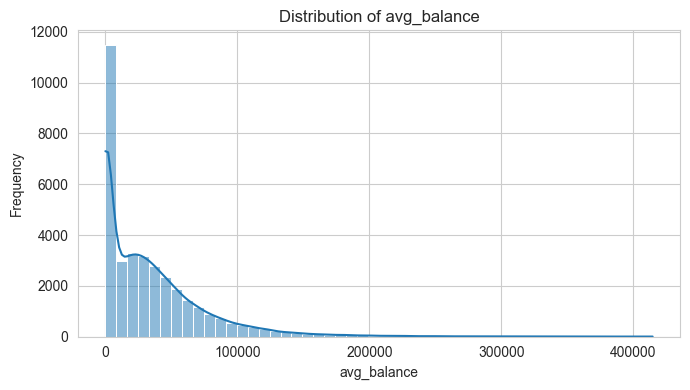

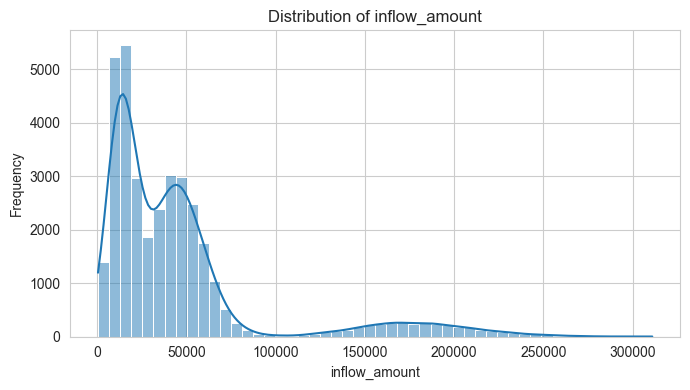

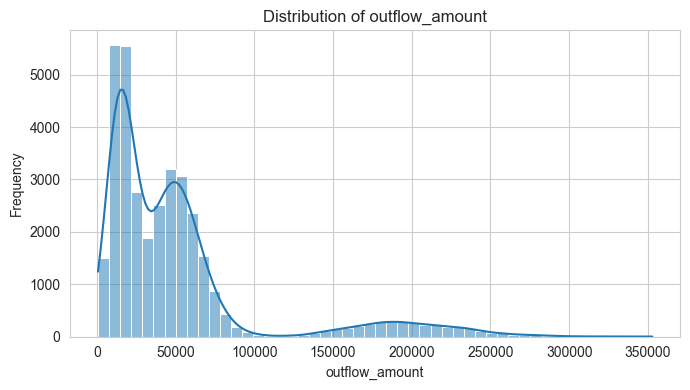

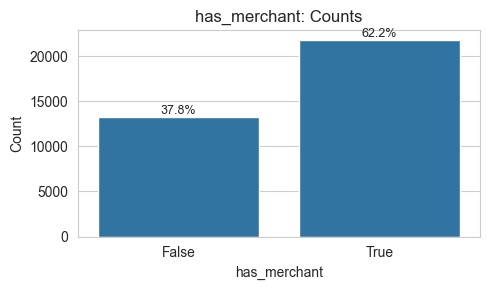

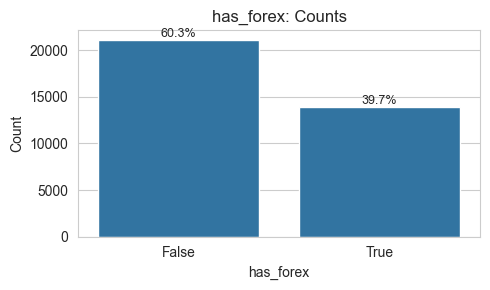

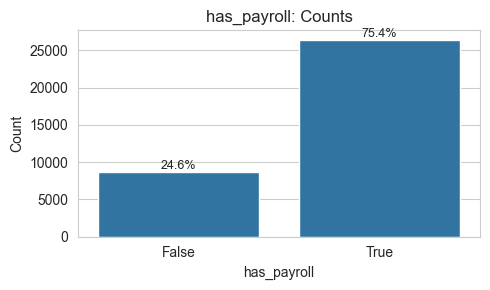

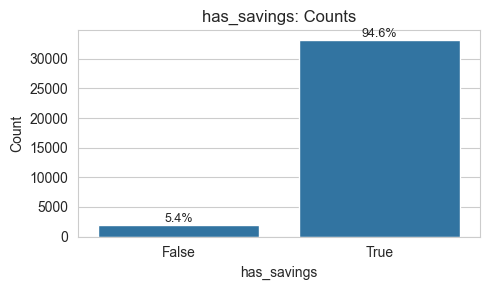

In [14]:


# ---------------- RUN CLEANING ----------------
if __name__ == "__main__":


    # ---------------- DESCRIPTIVE ANALYSIS ----------------
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_style("whitegrid")

    # 1) Summary statistics for key numeric columns
    num_cols = ["avg_balance","inflow_amount","outflow_amount",
                "avg_ticket_size","email_open_rate","email_ctr"]
    print("\n=== Summary Statistics (mean, median, min, max, std) ===")
    summary = df_clean[num_cols].agg(["count","mean","median","min","max","std"]).T
    print(summary)

    # 2) Frequency counts for flags
    flag_cols = ["intl_txn_flag","self_service_usage_flag",
                 "has_merchant","has_forex","has_payroll","has_savings"]
    print("\n=== Flag Distributions (counts & %) ===")
    for c in flag_cols:
        if c in df_clean.columns:
            counts = df_clean[c].value_counts(dropna=False)
            pct = df_clean[c].value_counts(normalize=True, dropna=False) * 100
            out = pd.concat([counts.rename("count"), pct.round(2).rename("pct")], axis=1)
            print(f"\n{c}:\n{out}")

    # 3) Range checks for logic validation
    print("\n=== Range Checks ===")
    if "days_active" in df_clean.columns:
        bad_days = df_clean[(df_clean["days_active"] < 0) | (df_clean["days_active"] > 31)]
        print(f"days_active outside 0–31: {len(bad_days)} rows")
    for rate_col in ["email_open_rate","email_ctr"]:
        if rate_col in df_clean.columns:
            bad_rate = df_clean[(df_clean[rate_col] < 0) | (df_clean[rate_col] > 100)]
            print(f"{rate_col} outside 0–100: {len(bad_rate)} rows")
    if {"email_ctr","email_open_rate"}.issubset(df_clean.columns):
        ctr_gt_open = df_clean[df_clean["email_ctr"] > df_clean["email_open_rate"]]
        print(f"email_ctr > email_open_rate: {len(ctr_gt_open)} rows")

    # 4) Outlier detection using IQR and percentiles
    def iqr_outlier_report(s: pd.Series, name: str):
        s = pd.to_numeric(s, errors="coerce").dropna()
        if s.empty:
            print(f"{name}: no data"); return
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        cnt_iqr = ((s < lo) | (s > hi)).sum()
        p01, p99 = s.quantile(0.01), s.quantile(0.99)
        cnt_pct = ((s < p01) | (s > p99)).sum()
        n = len(s)
        print(f"{name}: IQR outliers={cnt_iqr} ({cnt_iqr/n:.2%}), "
              f"Percentile(1/99) outliers={cnt_pct} ({cnt_pct/n:.2%}); "
              f"bounds(IQR)=[{lo:,.2f}, {hi:,.2f}], P01={p01:,.2f}, P99={p99:,.2f}")

    print("\n=== Outlier Detection (IQR & Percentiles) ===")
    for col in ["avg_balance","inflow_amount","outflow_amount"]:
        if col in df_clean.columns:
            iqr_outlier_report(df_clean[col], col)

    # 5) Visualizations
    # Histograms for balances & flows
    for col in [c for c in ["avg_balance","inflow_amount","outflow_amount"] if c in df_clean.columns]:
        plt.figure(figsize=(7,4))
        sns.histplot(df_clean[col].dropna(), bins=50, kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # Bar charts for adoption-related flags
    for flag in ["has_merchant","has_forex", "has_payroll", "has_savings"]:
        if flag in df_clean.columns:
            plt.figure(figsize=(5,3))
            ax = sns.countplot(x=df_clean[flag])
            plt.title(f"{flag}: Counts")
            plt.xlabel(flag)
            plt.ylabel("Count")
            total = len(df_clean)
            for p in ax.patches:
                height = p.get_height()
                pct = 100 * height / total if total else 0
                ax.annotate(f"{pct:.1f}%", (p.get_x()+p.get_width()/2, height),
                            ha="center", va="bottom", fontsize=9)
            plt.tight_layout()
            plt.show()



=== Analysis: Fact Client Monthly ===


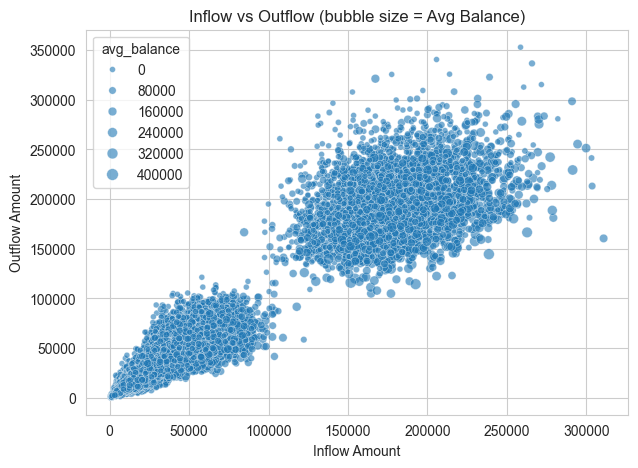

Correlation inflow_txn_cnt vs outflow_txn_cnt: 0.87


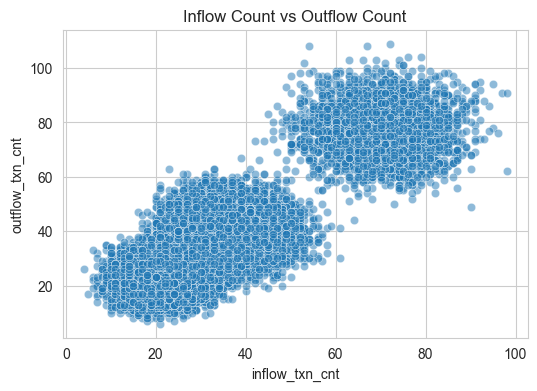

Correlation logins vs days_active: 0.72


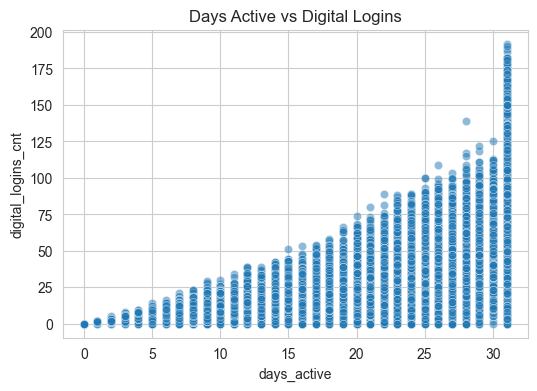

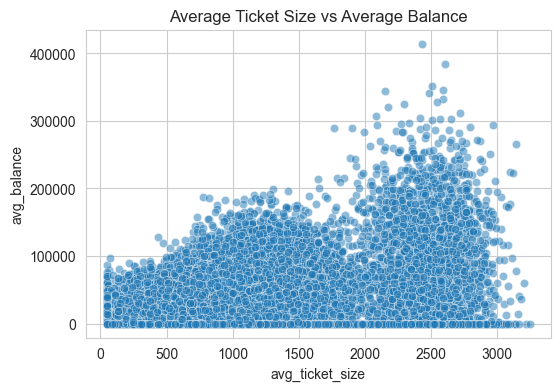

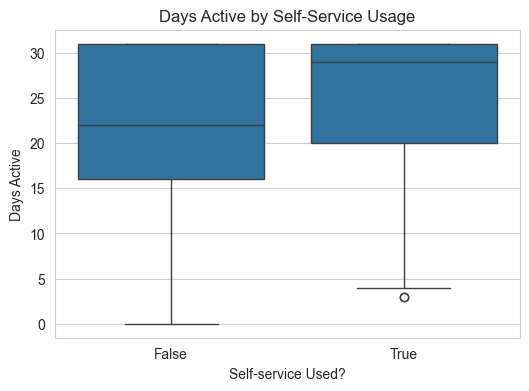

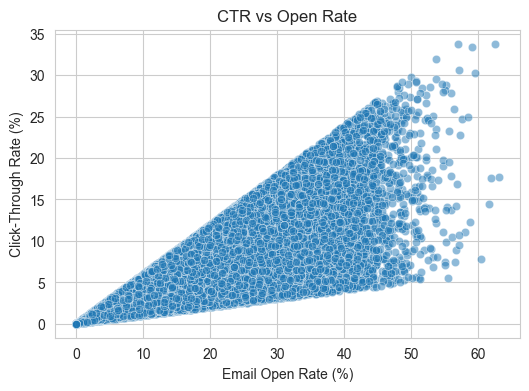

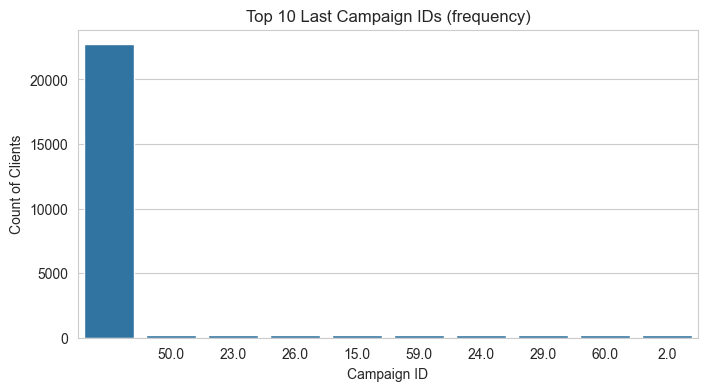

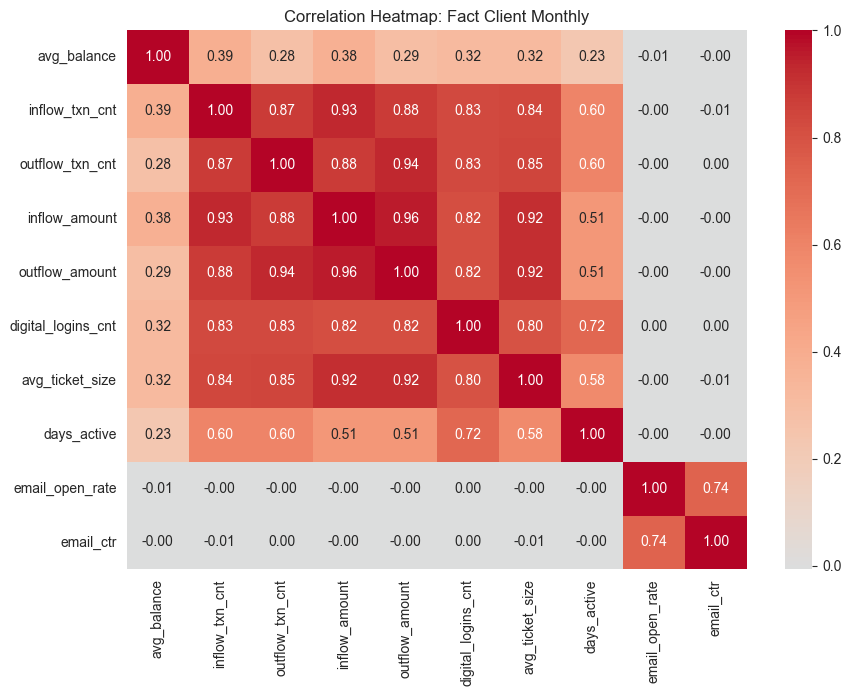

In [15]:
# ---------------- ANALYSIS: fact_client_monthly ----------------
print("\n=== Analysis: Fact Client Monthly ===")
 
# 1) Relationship between inflow, outflow and average balance
if {"inflow_amount","outflow_amount","avg_balance"}.issubset(df_clean.columns):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df_clean, x="inflow_amount", y="outflow_amount", size="avg_balance", alpha=0.6)
    plt.title("Inflow vs Outflow (bubble size = Avg Balance)")
    plt.xlabel("Inflow Amount")
    plt.ylabel("Outflow Amount")
    plt.show()
 
# 2) Correlation between inflow count and outflow count
if {"inflow_txn_cnt","outflow_txn_cnt"}.issubset(df_clean.columns):
    corr_val = df_clean["inflow_txn_cnt"].corr(df_clean["outflow_txn_cnt"])
    print(f"Correlation inflow_txn_cnt vs outflow_txn_cnt: {corr_val:.2f}")
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_clean,x="inflow_txn_cnt", y="outflow_txn_cnt", alpha=0.5)
    plt.title("Inflow Count vs Outflow Count")
    plt.show()
 
# 3) Digital logins vs Days active
if {"digital_logins_cnt","days_active"}.issubset(df_clean.columns):
    corr_val = df_clean["digital_logins_cnt"].corr(df_clean["days_active"])
    print(f"Correlation logins vs days_active: {corr_val:.2f}")
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_clean,x="days_active", y="digital_logins_cnt", alpha=0.5)
    plt.title("Days Active vs Digital Logins")
    plt.show()
 
# 4) Average ticket size vs Balance
if {"avg_ticket_size","avg_balance"}.issubset(df_clean.columns):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_clean,x="avg_ticket_size", y="avg_balance", alpha=0.5)
    plt.title("Average Ticket Size vs Average Balance")
    plt.show()
 
# 5) Self-service usage flag vs Activity
if "self_service_usage_flag" in df_clean.columns and "days_active" in df_clean.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="self_service_usage_flag", y="days_active", data=df_clean)
    plt.title("Days Active by Self-Service Usage")
    plt.xlabel("Self-service Used?")
    plt.ylabel("Days Active")
    plt.show()
 
# 6) Email engagement: CTR vs Open Rate
if {"email_open_rate","email_ctr"}.issubset(df_clean.columns):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_clean,x="email_open_rate", y="email_ctr", alpha=0.5)
    plt.title("CTR vs Open Rate")
    plt.xlabel("Email Open Rate (%)")
    plt.ylabel("Click-Through Rate (%)")
    plt.show()
 
# 7) Campaign exposure: last_campaign_sk
if "last_campaign_sk" in df_clean.columns:
    counts = df_clean["last_campaign_sk"].value_counts().head(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=counts.index.astype(str), y=counts.values)
    plt.title("Top 10 Last Campaign IDs (frequency)")
    plt.xlabel("Campaign ID")
    plt.ylabel("Count of Clients")
    plt.show()
 
# 8) Correlation heatmap for all numeric variables in fact_client_monthly
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    corr = df_clean[numeric_cols].corr()
    plt.figure(figsize=(10,7))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title("Correlation Heatmap: Fact Client Monthly")
    plt.show()